<a href="https://colab.research.google.com/github/shaheerakr/financial-analysis/blob/main/Autoencoders.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

The dataset is imported from: https://raw.githubusercontent.com/RalfKellner/data_transfer/main/sp500_alltimers.csv

- The dataset consists of stock returns from sp500 companies and I will be using this dataset for performing some analytics on them.

Breif overview of what is been done in the notebook. 

- I will be using the data from 2013 and 2014 as training set and 2015 as testing set.
- Import and prepare the data as you are used to
- Build a small Autoencoder with an Encoder output dimension of 3
- Take a look at the top 10 and lowest 10 in terms of square root of squared errors, plot their normalized returns (each close price divided by the first close price) over the whole time period and calculate the correlation, what do you see ? 
- Build several different Autoencoder with 3,5,8,11 Encoder output dimensions, both linear and non-linear (therefore 8 in Total).
- Compare the constiuants of top 40 and lowest 40 companies in terms of square root of squared erros (for comparison calculate the percentage of matching companies). 


# Importing libraries

In [ ]:
import pandas as pd
from datetime import datetime
from dateutil.relativedelta import relativedelta
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns

# Importing dataset
*   Importing dataset from the provided url
*   I am also making the date column as the index column
*   Droped extra date column



In [ ]:
datasetUri = "https://raw.githubusercontent.com/RalfKellner/data_transfer/main/sp500_alltimers.csv"
dataset = pd.read_csv(datasetUri)
dataset.set_index(pd.to_datetime(dataset.date), inplace = True)
dataset.drop(['date'], axis = 1, inplace = True)
dataset.head()

,AAPL,ABT,ADBE,ADM,ADP,ADSK,AEE,AEP,AIG,ALL,...,WFC,WHR,WM,WMB,WMT,WRK,WY,XEL,XOM,YUM
date,,,,,,,,,,,,,,,,,,,,,
1998-01-02,0.123676,8.664290,4.9977,10.592284,14.556592,8.9131,13.007511,16.675596,493.513336,25.293035,...,9.802009,28.258766,22.608261,9.080934,12.959832,NaN,7.992623,9.964503,14.441016,3.740663
1998-01-05,0.120823,8.712471,5.0671,10.622808,14.753723,9.0913,12.912563,16.614594,490.152191,24.946089,...,9.705754,28.684456,22.389481,9.239215,13.083271,NaN,8.105922,9.878420,14.280560,3.628285
1998-01-06,0.144131,8.567928,5.2368,10.378607,14.784045,9.3587,12.722677,16.573921,488.191773,24.685869,...,9.609494,28.946413,22.644733,9.041370,13.165551,NaN,8.085321,9.738531,13.770018,3.475768
1998-01-07,0.133190,8.624138,5.1597,11.019638,14.586929,9.0457,12.608740,16.512913,483.429932,24.703232,...,9.449069,28.193266,22.498867,8.843530,13.124411,NaN,7.817531,9.641684,14.207628,3.467741
1998-01-08,0.138423,8.736559,5.2060,10.958587,14.526262,9.2540,12.456830,16.553585,480.909332,24.460360,...,9.609494,28.356985,21.878969,8.645684,12.939268,NaN,7.570335,9.663206,13.901303,3.331276


# Preparing dataset
* Extracting the training data from 2013 till 2014 and validation data from 2015
* Exploring the datasets with some stats
* Handling the missing values
* Scaling the data

In [ ]:
df_train = dataset.loc['2013-01-01':'2014-12-31']
validation = dataset.loc['2015-01-01':'2015-12-31']

We can see that we have extracted the required data

In [ ]:
df_train.head()

,AAPL,ABT,ADBE,ADM,ADP,ADSK,AEE,AEP,AIG,ALL,...,WFC,WHR,WM,WMB,WMT,WRK,WY,XEL,XOM,YUM
date,,,,,,,,,,,,,,,,,,,,,
2013-01-02,16.862825,26.521122,38.34,21.917021,41.240841,36.94,22.726232,30.540476,29.703161,33.431534,...,26.308275,81.649239,26.777321,19.461533,55.663280,NaN,20.031267,20.018089,58.083363,39.864071
2013-01-03,16.649975,27.530655,37.75,21.741192,41.403294,36.37,22.631903,30.519480,29.458883,33.772682,...,26.090599,81.443565,26.871908,19.312847,55.309547,NaN,20.031267,19.959604,57.978611,40.113350
2013-01-04,16.186205,27.365166,38.13,22.337469,41.770576,36.36,22.631903,30.470507,29.556589,34.276260,...,26.225704,80.750252,26.864033,19.524443,55.518562,NaN,20.196188,20.032722,58.247051,40.552601
2013-01-07,16.090984,27.588587,37.94,21.412472,41.608131,36.09,22.348915,30.344572,29.255322,33.902637,...,26.098105,79.516029,26.777321,19.438664,54.987976,NaN,20.258036,19.820688,57.572655,40.297371
2013-01-08,16.134293,27.596867,38.14,21.664751,41.848274,36.30,22.450502,30.190641,29.027340,33.975738,...,26.053074,80.003624,26.832504,19.198469,55.140736,NaN,20.395472,19.857250,57.932770,38.605701


In [ ]:
df_train.tail()

,AAPL,ABT,ADBE,ADM,ADP,ADSK,AEE,AEP,AIG,ALL,...,WFC,WHR,WM,WMB,WMT,WRK,WY,XEL,XOM,YUM
date,,,,,,,,,,,,,,,,,,,,,
2014-12-24,25.206301,39.294323,74.74,42.352951,72.030868,60.99,37.053463,46.493122,46.439808,59.710922,...,43.943237,151.161316,43.208675,28.149984,72.972748,NaN,26.697199,28.604057,64.867691,44.989952
2014-12-26,25.651875,39.423294,74.67,42.600151,71.997063,61.03,37.575573,47.008781,46.555344,59.913639,...,43.895607,152.189331,43.377586,28.323774,73.378036,NaN,26.704487,28.880388,64.473412,45.206284
2014-12-29,25.633871,39.208347,74.13,42.368889,71.718193,60.76,37.907810,47.706451,46.613098,59.972767,...,44.237034,152.648010,43.529625,28.329985,73.150055,NaN,26.711780,29.409368,64.376587,45.465877
2014-12-30,25.321066,39.285740,73.08,42.177502,71.075989,60.51,37.298691,46.804031,46.629608,59.922073,...,44.006771,153.146179,43.563393,28.174812,73.276718,NaN,26.565975,28.722481,64.342003,45.292824
2014-12-31,24.839497,38.709648,72.70,41.467766,70.450653,60.06,36.491810,46.045704,46.217014,59.339260,...,43.530335,153.209473,43.343792,27.895483,72.508415,NaN,26.165011,28.359308,63.947727,45.027035


In [ ]:
validation.head()

,AAPL,ABT,ADBE,ADM,ADP,ADSK,AEE,AEP,AIG,ALL,...,WFC,WHR,WM,WMB,WMT,WRK,WY,XEL,XOM,YUM
date,,,,,,,,,,,,,,,,,,,,,
2015-01-02,24.603201,38.606464,72.34,41.483715,70.383064,59.53,36.381054,46.371792,46.299538,59.229439,...,43.435051,152.632187,43.706963,28.069288,72.525284,NaN,26.325396,28.517214,64.210587,44.717999
2015-01-05,23.910095,38.615059,71.98,40.048286,70.332352,58.66,36.017166,45.689297,45.383606,58.055336,...,42.243961,149.484772,43.267803,26.958179,72.314224,NaN,26.325396,28.193506,62.453663,43.809418
2015-01-06,23.912340,38.176552,70.53,39.258808,69.749283,57.50,35.597904,45.939549,44.739986,58.013103,...,41.362545,148.251160,43.301586,26.591961,72.871460,NaN,26.296234,28.343517,62.121632,43.271694
2015-01-07,24.247650,38.486084,71.11,39.848923,70.357712,57.38,35.874775,46.591709,44.954536,58.967613,...,41.608711,151.738586,43.335358,26.449190,74.804894,NaN,26.376431,28.588268,62.751095,44.705635
2015-01-08,25.179295,39.277130,72.92,39.266800,71.971718,58.80,36.001339,46.993622,44.756496,60.099483,...,42.529831,155.653030,43.833668,26.703686,76.383736,NaN,26.660749,28.919855,63.795547,45.484425


In [ ]:
validation.tail()

,AAPL,ABT,ADBE,ADM,ADP,ADSK,AEE,AEP,AIG,ALL,...,WFC,WHR,WM,WMB,WMT,WRK,WY,XEL,XOM,YUM
date,,,,,,,,,,,,,,,,,,,,,
2015-12-24,24.724871,39.601025,94.30,29.956554,74.395729,61.85,36.012440,45.974609,51.606316,54.340660,...,44.707336,120.609543,46.485737,16.455170,52.786758,32.904942,23.293200,29.310154,56.754951,46.754059
2015-12-28,24.447935,39.539558,94.20,29.833946,74.231262,61.86,36.309250,46.132046,51.522682,53.910336,...,44.593159,120.133789,46.903343,16.389107,52.717342,32.991703,23.179462,29.638191,56.332840,46.652966
2015-12-29,24.887367,40.233246,95.33,30.316198,75.174828,62.22,36.375194,46.360348,52.308895,54.383694,...,45.090641,121.085335,47.286163,16.428743,53.463627,33.165230,23.209793,29.703802,56.633320,46.905693
2015-12-30,24.562376,39.750298,95.28,30.144558,74.776634,62.25,36.276276,46.368225,52.283806,54.056652,...,44.764423,119.803169,46.964260,16.124876,53.524372,33.085709,23.005072,29.851408,55.882134,46.634010
2015-12-31,24.090902,39.434196,93.94,29.981071,73.339615,60.93,35.641430,45.872261,51.832149,53.436981,...,44.332188,118.432365,46.433529,16.977028,53.194626,32.984474,22.732101,29.449556,55.767662,46.153835


Exploring the training and validation datasets



In [ ]:
df_train.describe()

,AAPL,ABT,ADBE,ADM,ADP,ADSK,AEE,AEP,AIG,ALL,...,WFC,WHR,WM,WMB,WMT,WRK,WY,XEL,XOM,YUM
count,504.000000,504.000000,504.000000,504.000000,504.000000,504.000000,504.000000,504.000000,504.000000,504.000000,...,504.000000,504.000000,504.000000,504.000000,504.000000,0.0,504.000000,504.000000,504.000000,504.000000
mean,17.653091,32.358352,57.128234,31.892318,55.147795,46.490040,28.330713,36.193478,39.832801,45.148895,...,35.077019,109.163584,34.977200,25.189138,62.903429,NaN,21.779848,22.756987,63.243248,43.730990
std,3.814202,3.177670,11.657057,5.635344,7.321448,8.226413,3.142413,4.042510,4.759492,5.847642,...,5.121715,16.191697,3.592469,5.604069,3.379070,NaN,1.761425,1.937958,4.003690,2.794778
min,12.064584,26.521122,37.730000,21.412472,41.240841,33.480000,22.348915,30.169643,28.367811,33.431534,...,26.053074,77.946594,26.777321,18.472998,54.907600,NaN,18.538162,19.674467,56.721420,37.039513
25%,14.265470,29.993309,45.687500,26.917613,50.598392,38.650000,25.757077,33.023665,37.198151,40.451582,...,31.439946,98.928169,33.054757,20.707593,61.243485,NaN,20.589697,21.194595,59.368962,41.784265
50%,16.711457,32.016891,59.060000,31.993080,55.580927,47.170000,27.506947,35.144735,40.627781,44.372395,...,34.977980,111.459663,34.612036,22.857051,63.134216,NaN,21.319101,22.380586,63.267443,43.822596
75%,20.931068,34.890373,68.045000,35.530034,58.748080,53.932500,30.822185,39.488069,43.771591,49.098675,...,39.955955,118.104147,36.967914,28.655813,64.206854,NaN,22.824069,24.053209,66.561642,45.473302
max,26.779306,39.870407,76.020000,42.831425,72.419586,62.000000,37.907810,47.706451,46.629608,59.972767,...,44.237034,153.209473,43.563393,36.095497,73.499329,NaN,26.711780,29.409368,71.186279,51.168571


We can see that "WRK" do not have any data as the count is 0 so it is better to remove it from datasets

In [ ]:
df_train.drop('WRK',inplace=True, axis=1)

/usr/local/lib/python3.8/dist-packages/pandas/core/frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [ ]:
validation.drop('WRK',inplace=True,axis=1)

In [ ]:
df_train.describe()

,AAPL,ABT,ADBE,ADM,ADP,ADSK,AEE,AEP,AIG,ALL,...,WBA,WFC,WHR,WM,WMB,WMT,WY,XEL,XOM,YUM
count,504.000000,504.000000,504.000000,504.000000,504.000000,504.000000,504.000000,504.000000,504.000000,504.000000,...,504.000000,504.000000,504.000000,504.000000,504.000000,504.000000,504.000000,504.000000,504.000000,504.000000
mean,17.653091,32.358352,57.128234,31.892318,55.147795,46.490040,28.330713,36.193478,39.832801,45.148895,...,45.006907,35.077019,109.163584,34.977200,25.189138,62.903429,21.779848,22.756987,63.243248,43.730990
std,3.814202,3.177670,11.657057,5.635344,7.321448,8.226413,3.142413,4.042510,4.759492,5.847642,...,8.316213,5.121715,16.191697,3.592469,5.604069,3.379070,1.761425,1.937958,4.003690,2.794778
min,12.064584,26.521122,37.730000,21.412472,41.240841,33.480000,22.348915,30.169643,28.367811,33.431534,...,28.128389,26.053074,77.946594,26.777321,18.472998,54.907600,18.538162,19.674467,56.721420,37.039513
25%,14.265470,29.993309,45.687500,26.917613,50.598392,38.650000,25.757077,33.023665,37.198151,40.451582,...,37.780581,31.439946,98.928169,33.054757,20.707593,61.243485,20.589697,21.194595,59.368962,41.784265
50%,16.711457,32.016891,59.060000,31.993080,55.580927,47.170000,27.506947,35.144735,40.627781,44.372395,...,45.855253,34.977980,111.459663,34.612036,22.857051,63.134216,21.319101,22.380586,63.267443,43.822596
75%,20.931068,34.890373,68.045000,35.530034,58.748080,53.932500,30.822185,39.488069,43.771591,49.098675,...,51.972179,39.955955,118.104147,36.967914,28.655813,64.206854,22.824069,24.053209,66.561642,45.473302
max,26.779306,39.870407,76.020000,42.831425,72.419586,62.000000,37.907810,47.706451,46.629608,59.972767,...,60.694893,44.237034,153.209473,43.563393,36.095497,73.499329,26.711780,29.409368,71.186279,51.168571


In [ ]:
validation.describe()

,AAPL,ABT,ADBE,ADM,ADP,ADSK,AEE,AEP,AIG,ALL,...,WBA,WFC,WHR,WM,WMB,WMT,WY,XEL,XOM,YUM
count,252.000000,252.000000,252.000000,252.000000,252.000000,252.000000,252.000000,252.000000,252.000000,252.000000,...,252.000000,252.000000,252.000000,252.000000,252.000000,252.000000,252.000000,252.000000,252.000000,252.000000
mean,27.249668,40.312336,80.967817,37.028331,72.045807,56.123532,33.703054,43.821578,48.732329,56.129846,...,68.041479,44.121020,142.309424,44.168611,28.910094,61.916619,23.487971,27.899302,58.253506,50.240085
std,1.690697,2.256079,6.373760,3.618284,2.627097,5.354099,1.771147,1.722346,3.236753,3.537986,...,4.293133,1.588491,14.777703,1.970368,4.923615,7.832866,1.624654,1.117742,3.442699,4.586771
min,23.500525,34.099461,69.990000,27.937653,62.856991,43.140000,30.296652,40.630016,40.325394,48.558823,...,58.292107,40.274696,114.722984,39.730484,14.228998,48.553192,19.952669,25.690493,48.732277,42.341850
25%,25.851829,38.747592,76.490000,35.405464,70.394102,52.495000,32.280226,42.749125,46.290234,53.704500,...,66.294603,43.105888,129.454277,42.495514,26.443965,54.912783,22.576649,27.062115,56.164624,46.101719
50%,27.386204,40.181404,79.825000,38.004515,72.613499,56.770000,33.614540,43.543938,48.980707,56.816010,...,68.251156,44.256863,142.055771,44.448545,30.075459,62.190222,23.532895,27.761793,58.656185,49.525393
75%,28.721487,42.152284,84.070000,38.792399,74.125338,60.982500,35.363360,44.550740,51.530916,59.365831,...,69.955599,45.233876,155.306908,45.946357,32.137946,68.593025,24.368899,28.852256,60.804443,55.084881
max,30.069084,44.697701,95.560000,42.881332,77.887985,65.290000,36.816139,48.965263,53.521683,61.307373,...,77.041931,47.091572,170.618973,47.286163,38.716778,76.383736,26.748241,30.183031,65.070213,59.286823


check if there are any missing values

In [ ]:
df_train.isnull().values.ravel().sum()

0

In [ ]:
validation.isnull().values.ravel().sum()

0

After removing the "WRK" column from the data we do not have any missing values aswell so we do not need to handle them.

Now I will scale the datasets to normalize it for the nural network usage

In [ ]:
scaler = MinMaxScaler()
#train the scaler on the training dataset only to prevent information leakage
scaler.fit(df_train)
df_train_s, validation_s = scaler.transform(df_train), scaler.transform(validation)

# Building the autoencoder
The small autoencoder with output dimension of 3

In [ ]:
# define encoder 
encoder = tf.keras.Sequential([
    tf.keras.layers.Dense(3, input_dim = (df_train_s.shape[1]), use_bias = False)
    #tf.keras.layers.Dense(train_df_s.shape[1], input_dim = (train_df_s.shape[1]), activation = 'sigmoid', use_bias = False), 
    #tf.keras.layers.Dense(1, use_bias = False)
])

# define decoder
decoder = tf.keras.Sequential([
    tf.keras.layers.Dense(df_train_s.shape[1], input_dim = (3), use_bias = False)
])

# define autoencoder with mean squared error as recreation loss
autoencoder = tf.keras.Sequential([encoder, decoder])
autoencoder.compile(loss = 'mse', optimizer = 'Adam')
autoencoder.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 3)                 576       
                                                                 
 sequential_1 (Sequential)   (None, 192)               576       
                                                                 
Total params: 1,152
Trainable params: 1,152
Non-trainable params: 0
_________________________________________________________________


Training the autoencoder, I am also using earlystopping to prevent overfitting of the autoencoder
I am also plotting the training and validation loss for visualizing them

Epoch 1/500
16/16 [==============================] - 3s 50ms/step - loss: 0.3050 - val_loss: 0.8031
Epoch 2/500
16/16 [==============================] - 0s 19ms/step - loss: 0.2720 - val_loss: 0.6659
Epoch 3/500
16/16 [==============================] - 1s 41ms/step - loss: 0.2174 - val_loss: 0.5089
Epoch 4/500
16/16 [==============================] - 1s 33ms/step - loss: 0.1568 - val_loss: 0.3620
Epoch 5/500
16/16 [==============================] - 0s 23ms/step - loss: 0.1016 - val_loss: 0.2548
Epoch 6/500
16/16 [==============================] - 0s 23ms/step - loss: 0.0616 - val_loss: 0.1969
Epoch 7/500
16/16 [==============================] - 0s 19ms/step - loss: 0.0387 - val_loss: 0.1717
Epoch 8/500
16/16 [==============================] - 0s 30ms/step - loss: 0.0276 - val_loss: 0.1637
Epoch 9/500
16/16 [==============================] - 0s 26ms/step - loss: 0.0227 - val_loss: 0.1600
Epoch 10/500
16/16 [==============================] - 0s 17ms/step - loss: 0.0209 - val_loss: 0.1609

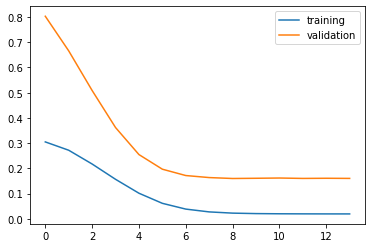

In [ ]:
my_callback = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', patience = 5)
fit_autoencoder = autoencoder.fit(df_train_s, df_train_s, epochs = 500, callbacks = [my_callback], validation_data = (validation_s, validation_s))
plt.plot(fit_autoencoder.history['loss'], label="training")
plt.plot(fit_autoencoder.history['val_loss'], label="validation")
plt.legend()
plt.show()

# Evaluating the results of autoencoder
Take a look at the top 10 and lowest 10 in terms of square root of squared errors, plot their normalized returns (each close price divided by the first close price) over the whole time period and calculate the correlation, what do you see ?
* Generating the data using autoencoder.
* Calculating the root mean squared error of predictions of each company for the whole time period.
* Extracting the top 10 and the lowest 10 companies in terms of error by using sorting.
* Plot the normalized returns of the top and bottom 10 companies using matplotlib.
* Finding corelation of the normalized returns between top and bottom 10 compaines using numpy correlation function

In [ ]:
X_train_hat = autoencoder.predict(df_train_s)
X_test_hat = autoencoder.predict(validation_s)

# differences of original data and recreations
Error_train = (df_train_s - X_train_hat)
Error_test = (validation_s - X_test_hat)

error_train = pd.DataFrame(Error_train, columns = df_train.columns, index = df_train.index)
error_test = pd.DataFrame(Error_test, columns = validation.columns, index = validation.index)


# square root of squared errors
error_train_rsq = error_train.apply(lambda x: np.sqrt(x**2))
error_test_rsq = error_test.apply(lambda x: np.sqrt(x**2))

# avereage error per day
error_per_day_train = error_train_rsq.mean(axis = 1)
error_per_day_test = error_test_rsq.mean(axis = 1)
# average error per company
error_per_company_train = error_train_rsq.mean(axis = 0)
error_per_company_test = error_test_rsq.mean(axis = 0)

8/8 [==============================] - 0s 3ms/step


Creating the dataframe with the generated data from autoencoder

In [ ]:
df_train_hat = pd.DataFrame(X_train_hat, columns=df_train.columns, index= df_train.index)
df_validation_hat = pd.DataFrame(X_test_hat, columns=validation.columns, index = validation.index)

In [ ]:
df_train_hat.head()

,AAPL,ABT,ADBE,ADM,ADP,ADSK,AEE,AEP,AIG,ALL,...,WBA,WFC,WHR,WM,WMB,WMT,WY,XEL,XOM,YUM
date,,,,,,,,,,,,,,,,,,,,,
2013-01-02,0.050527,0.048334,0.064211,0.056059,0.054881,0.054598,0.043388,0.038557,0.067642,0.051242,...,0.060921,0.058050,0.055594,0.053620,0.050014,0.037295,0.041156,0.036371,0.056471,0.046866
2013-01-03,0.051305,0.050770,0.067384,0.058713,0.054672,0.054689,0.044735,0.041881,0.070629,0.052254,...,0.057969,0.058501,0.055623,0.051011,0.050528,0.042635,0.045200,0.035990,0.058724,0.047303
2013-01-04,0.061133,0.069630,0.082757,0.078077,0.068153,0.072134,0.059959,0.057760,0.095712,0.068413,...,0.075954,0.078327,0.062263,0.070618,0.062569,0.067645,0.062747,0.048574,0.070677,0.069108
2013-01-07,0.057853,0.065625,0.077837,0.073581,0.064787,0.068539,0.056677,0.054130,0.090283,0.064777,...,0.072893,0.074351,0.059060,0.067779,0.059305,0.063132,0.058703,0.046271,0.066569,0.065648
2013-01-08,0.049154,0.062250,0.069230,0.068511,0.055929,0.061599,0.052454,0.052568,0.084769,0.058696,...,0.062804,0.067712,0.047261,0.060487,0.051527,0.066892,0.057567,0.041806,0.058036,0.062777


extracting top and bottom 10 companies

In [ ]:
error_per_company_train= error_per_company_train.sort_values()
top_10 = error_per_company_train.head(10)
bottom_10 = error_per_company_train.tail(10)

doing same thing for validation data

In [ ]:
error_per_company_test= error_per_company_test.sort_values()
top_10_test = error_per_company_test.head(10)
bottom_10_test = error_per_company_test.tail(10)

Calculating and Ploting the normalized returns on generated data from autoencoder and from the actual data

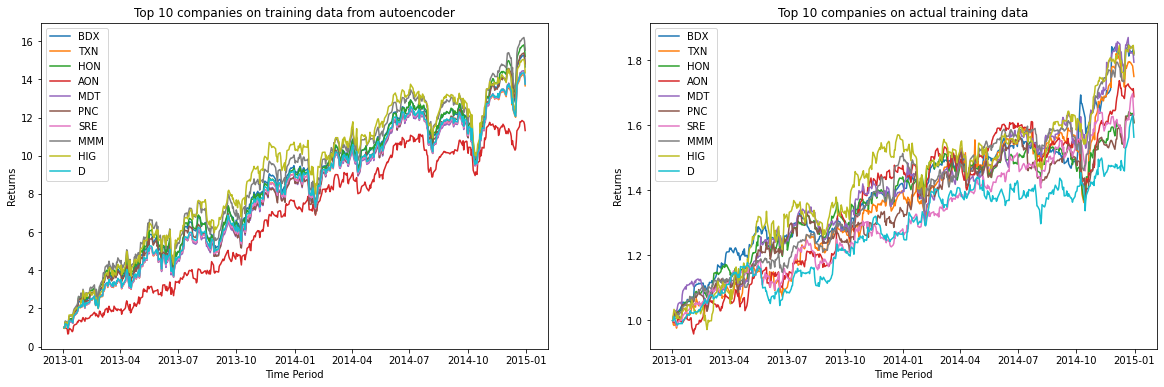

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 6))

for i in top_10.index:
    returns = df_train_hat[i] / df_train_hat[i][0]
    ax1.plot(returns)
ax1.set_title("Top 10 companies on training data from autoencoder")
ax1.set_xlabel("Time Period")
ax1.set_ylabel("Returns")
ax1.legend(top_10.index)

for i in top_10.index:
    returns = df_train[i] / df_train[i][0]
    ax2.plot(returns)
ax2.set_title("Top 10 companies on actual training data")
ax2.set_xlabel("Time Period")
ax2.set_ylabel("Returns")
ax2.legend(top_10.index)

plt.show()

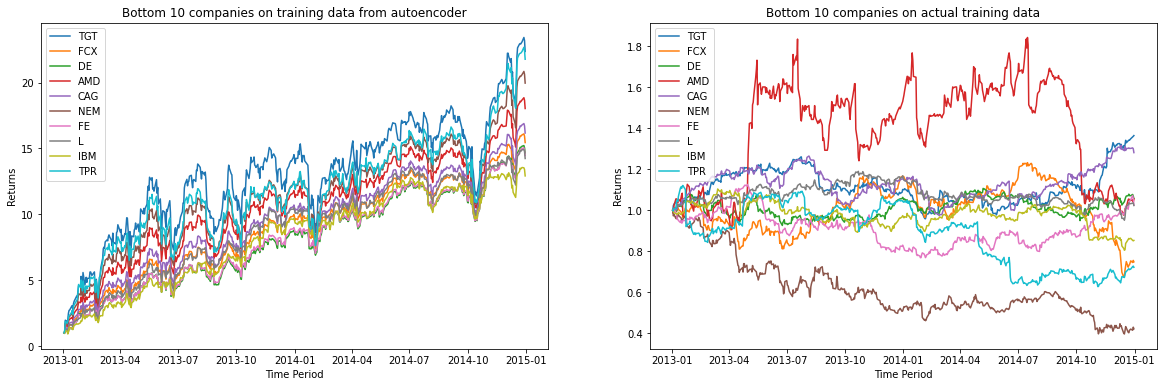

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 6))

for i in bottom_10.index:
    returns = df_train_hat[i] / df_train_hat[i][0]
    ax1.plot(returns)
ax1.set_title("Bottom 10 companies on training data from autoencoder")
ax1.set_xlabel("Time Period")
ax1.set_ylabel("Returns")
ax1.legend(bottom_10.index)

for i in bottom_10.index:
    returns = df_train[i] / df_train[i][0]
    ax2.plot(returns)
ax2.set_title("Bottom 10 companies on actual training data")
ax2.set_xlabel("Time Period")
ax2.set_ylabel("Returns")
ax2.legend(bottom_10.index)

plt.show()

I am also collecting the normalized returns on the validation data which i would use later on for finding the corelation

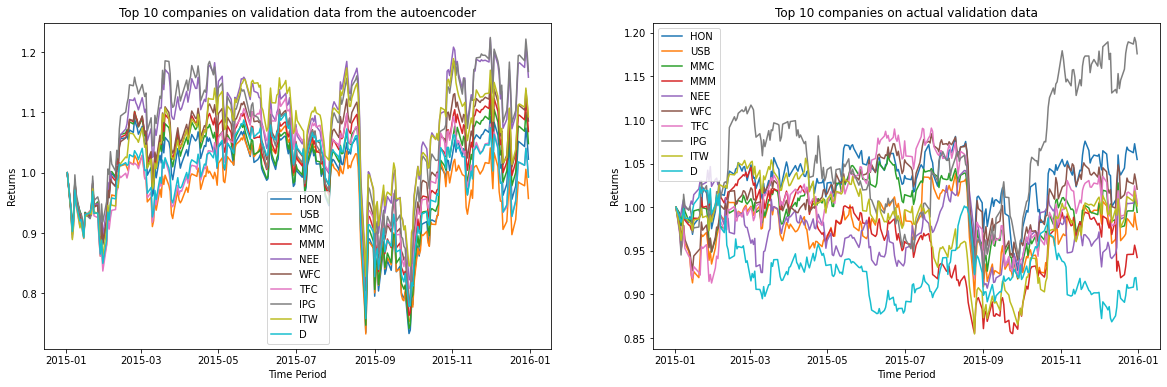

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 6))

normalized_returns_hat = []
for i in top_10_test.index:
    returns = df_validation_hat[i] / df_validation_hat[i][0]
    normalized_returns_hat.append(returns)
    ax1.plot(returns)
ax1.set_title("Top 10 companies on validation data from the autoencoder")
ax1.set_xlabel("Time Period")
ax1.set_ylabel("Returns")
ax1.legend(top_10_test.index)

normalized_returns = []
for i in top_10_test.index:
    returns = validation[i] / validation[i][0]
    normalized_returns.append(returns)
    ax2.plot(returns)
ax2.set_title("Top 10 companies on actual validation data")
ax2.set_xlabel("Time Period")
ax2.set_ylabel("Returns")
ax2.legend(top_10_test.index)

plt.show()

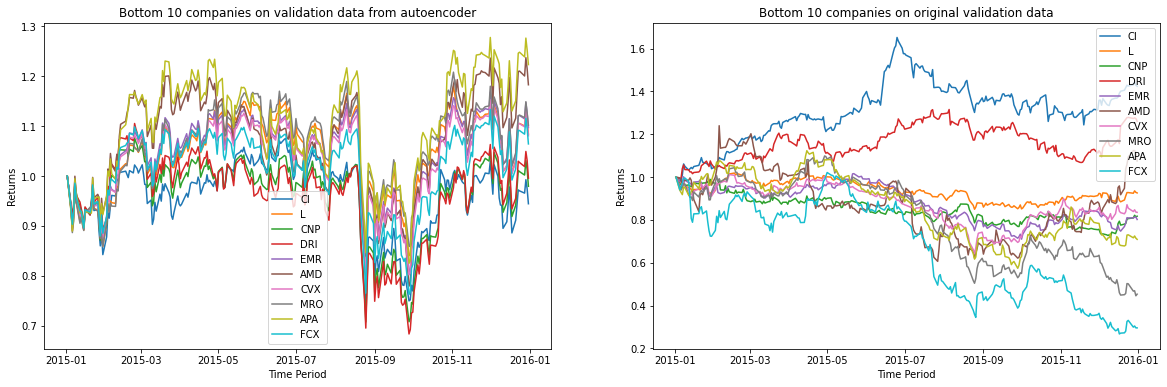

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 6))

for i in bottom_10_test.index:
    returns = df_validation_hat[i] / df_validation_hat[i][0]
    normalized_returns_hat.append(returns)
    ax1.plot(returns)
ax1.set_title("Bottom 10 companies on validation data from autoencoder")
ax1.set_xlabel("Time Period")
ax1.set_ylabel("Returns")
ax1.legend(bottom_10_test.index)

for i in bottom_10_test.index:
    returns = validation[i] / validation[i][0]
    normalized_returns.append(returns)
    ax2.plot(returns)
ax2.set_title("Bottom 10 companies on original validation data")
ax2.set_xlabel("Time Period")
ax2.set_ylabel("Returns")
ax2.legend(bottom_10_test.index)

plt.show()

*   Now finding the correlation of normalized returns between top 10 and bottom 10 companies using numpy correlation function.

*   I am also plotting the corelation matrix to visualize the correlation of normalized returns.

*   I am doing this for both actual and generated data from autoencoder.



correlation from autoencoder data

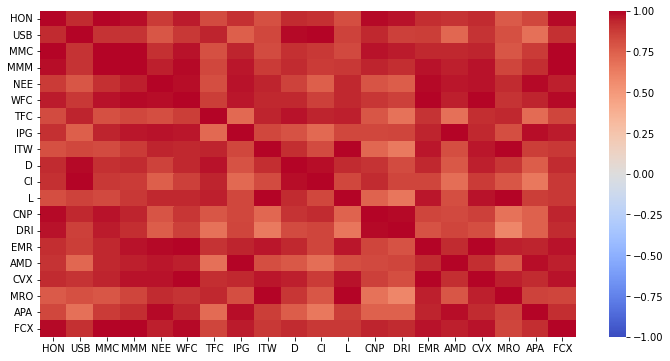

In [ ]:
correlation_matrix = np.corrcoef(normalized_returns_hat)

lables = list(top_10_test.index)
lables.extend(list(bottom_10_test.index))
plt.figure(figsize=(12,6))
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm',xticklabels=lables,yticklabels=lables,vmin=-1,vmax=1)
plt.show()

The heatmap shows a strong positive correlation between the normalized returns of each other companies for almost all the companies, except few in the middle which have a week positive correlation. Technincally this would mean that the returns of the companies are very much positivly corelated to each other that would indicate that if one of the companies returns increase others will also tend to increase.

correlation from original data

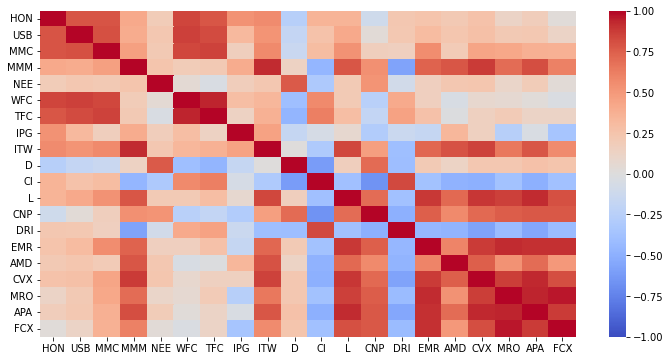

In [ ]:
correlation_matrix = np.corrcoef(normalized_returns)

lables = list(top_10_test.index)
lables.extend(list(bottom_10_test.index))
plt.figure(figsize=(12,6))
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm',xticklabels=lables,yticklabels=lables,vmin=-1,vmax=1)
plt.show()

This heatmap shows a diverse set of correlation between diffrent parts of the heatmap.
* The dark red parts which are clustered together in the bottom right and the top left show a strong positive correlation between each other.
* The white parts in the heatmap shows no correlation between them.
* There are few dark blue parts which show a negitive correlation between each other.
* The lighter shades of red and blue, shows week correlation between each other.

It is important to note that correlation does not imply causation. Just because two values are positively correlated, it does not necessarily mean that one causes the other. Other factors may be at play that are causing both values to change in a similar way.

# Build several different Autoencoder with 3,5,8,11 Encoder output dimensions, both linear and non-linear

Linear autoencoder
*   I will define an architecture for a linear autoencoder.
*   I will use the linear activation function to make my autoencoder linear.
*   I will use the same architecture to define four autoencoders with 3,5,8,11 output dimensions.
*   I will train all the autoencoders after defination of each.
*   I am also using earlystopping to avoid overfitting
*   I am also using the mean squared error as validation loss as we will also use this for further evaluavation of these autoencoders.



Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_3 (Sequential)   (None, 3)                 576       
                                                                 
 sequential_4 (Sequential)   (None, 192)               576       
                                                                 
Total params: 1,152
Trainable params: 1,152
Non-trainable params: 0
_________________________________________________________________
Epoch 1/500
16/16 [==============================] - 0s 11ms/step - loss: 0.2902 - val_loss: 0.7375
Epoch 2/500
16/16 [==============================] - 0s 5ms/step - loss: 0.2442 - val_loss: 0.6022
Epoch 3/500
16/16 [==============================] - 0s 5ms/step - loss: 0.1909 - val_loss: 0.4534
Epoch 4/500
16/16 [==============================] - 0s 5ms/step - loss: 0.1333 - val_loss: 0.3296
Epoch 5/500
16/16 [==============================] 

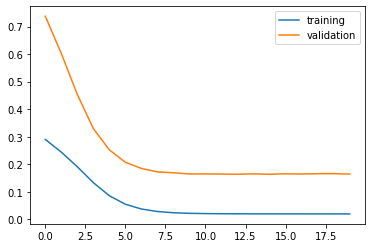

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_6 (Sequential)   (None, 5)                 960       
                                                                 
 sequential_7 (Sequential)   (None, 192)               960       
                                                                 
Total params: 1,920
Trainable params: 1,920
Non-trainable params: 0
_________________________________________________________________
Epoch 1/500
16/16 [==============================] - 0s 10ms/step - loss: 0.2843 - val_loss: 0.7418
Epoch 2/500
16/16 [==============================] - 0s 5ms/step - loss: 0.2331 - val_loss: 0.5846
Epoch 3/500
16/16 [==============================] - 0s 5ms/step - loss: 0.1620 - val_loss: 0.4102
Epoch 4/500
16/16 [==============================] - 0s 5ms/step - loss: 0.0979 - val_loss: 0.2815
Epoch 5/500
16/16 [==============================] 

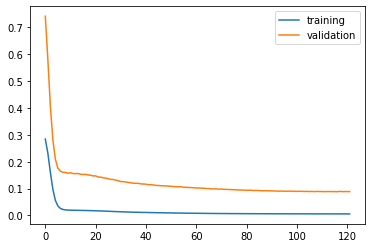

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_9 (Sequential)   (None, 8)                 1536      
                                                                 
 sequential_10 (Sequential)  (None, 192)               1536      
                                                                 
Total params: 3,072
Trainable params: 3,072
Non-trainable params: 0
_________________________________________________________________
Epoch 1/500
16/16 [==============================] - 0s 11ms/step - loss: 0.2732 - val_loss: 0.6724
Epoch 2/500
16/16 [==============================] - 0s 5ms/step - loss: 0.1901 - val_loss: 0.4722
Epoch 3/500
16/16 [==============================] - 0s 5ms/step - loss: 0.1143 - val_loss: 0.3110
Epoch 4/500
16/16 [==============================] - 0s 4ms/step - loss: 0.0612 - val_loss: 0.2220
Epoch 5/500
16/16 [==============================]

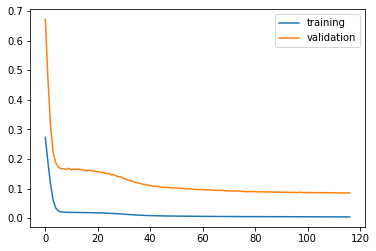

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_12 (Sequential)  (None, 11)                2112      
                                                                 
 sequential_13 (Sequential)  (None, 192)               2112      
                                                                 
Total params: 4,224
Trainable params: 4,224
Non-trainable params: 0
_________________________________________________________________
Epoch 1/500
16/16 [==============================] - 0s 11ms/step - loss: 0.2979 - val_loss: 0.7780
Epoch 2/500
16/16 [==============================] - 0s 4ms/step - loss: 0.2122 - val_loss: 0.5430
Epoch 3/500
16/16 [==============================] - 0s 5ms/step - loss: 0.1229 - val_loss: 0.3455
Epoch 4/500
16/16 [==============================] - 0s 6ms/step - loss: 0.0595 - val_loss: 0.2411
Epoch 5/500
16/16 [==============================]

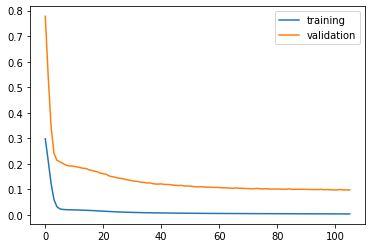

In [ ]:
no_dims = [3, 5, 8, 11]
autoencoders = []
for dim in no_dims: 
  # define encoder
  encoder = tf.keras.Sequential([
      tf.keras.layers.Dense(dim, input_dim=(df_train_s.shape[1]), activation='linear', use_bias=False)
  ])

  # define decoder 
  decoder = tf.keras.Sequential([
      tf.keras.layers.Dense(df_train_s.shape[1], input_dim=( dim ), activation='linear', use_bias=False)
  ])

  # define autoencoder with mean squared error as recreation loss
  autoencoder = tf.keras.Sequential([encoder, decoder])

  autoencoder.compile(loss='mse', optimizer='Adam')

  autoencoder.summary()

  my_callback = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', patience = 5)
  fit_autoencoder = autoencoder.fit(df_train_s, df_train_s, epochs = 500, callbacks = [my_callback], verbose=1, validation_data = (validation_s, validation_s))
  plt.plot(fit_autoencoder.history['loss'], label="training")
  plt.plot(fit_autoencoder.history['val_loss'], label="validation")
  plt.legend()
  plt.show()
  autoencoders.append(autoencoder)

Non Linear autoencoder

*   I will build an architecture for non-linear autoencoder with a non-linear activation function (tanh) 
*   Rest of the parameters and training strategy I will use similar to the linear autoencoder.



Model: "sequential_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_15 (Sequential)  (None, 3)                 576       
                                                                 
 sequential_16 (Sequential)  (None, 192)               576       
                                                                 
Total params: 1,152
Trainable params: 1,152
Non-trainable params: 0
_________________________________________________________________
Epoch 1/500
16/16 [==============================] - 0s 11ms/step - loss: 0.2996 - val_loss: 0.8177
Epoch 2/500
16/16 [==============================] - 0s 5ms/step - loss: 0.2712 - val_loss: 0.7628
Epoch 3/500
16/16 [==============================] - 0s 4ms/step - loss: 0.2407 - val_loss: 0.7032
Epoch 4/500
16/16 [==============================] - 0s 5ms/step - loss: 0.2085 - val_loss: 0.6367
Epoch 5/500
16/16 [==============================]

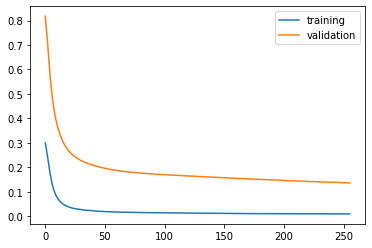

Model: "sequential_20"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_18 (Sequential)  (None, 5)                 960       
                                                                 
 sequential_19 (Sequential)  (None, 192)               960       
                                                                 
Total params: 1,920
Trainable params: 1,920
Non-trainable params: 0
_________________________________________________________________
Epoch 1/500
16/16 [==============================] - 1s 11ms/step - loss: 0.2948 - val_loss: 0.8001
Epoch 2/500
16/16 [==============================] - 0s 5ms/step - loss: 0.2532 - val_loss: 0.6990
Epoch 3/500
16/16 [==============================] - 0s 4ms/step - loss: 0.2055 - val_loss: 0.6090
Epoch 4/500
16/16 [==============================] - 0s 5ms/step - loss: 0.1629 - val_loss: 0.5309
Epoch 5/500
16/16 [==============================]

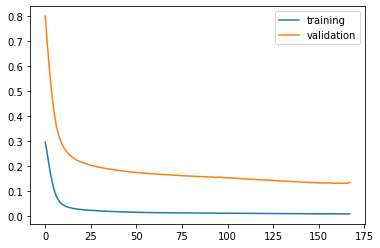

Model: "sequential_23"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_21 (Sequential)  (None, 8)                 1536      
                                                                 
 sequential_22 (Sequential)  (None, 192)               1536      
                                                                 
Total params: 3,072
Trainable params: 3,072
Non-trainable params: 0
_________________________________________________________________
Epoch 1/500
16/16 [==============================] - 0s 10ms/step - loss: 0.2834 - val_loss: 0.7533
Epoch 2/500
16/16 [==============================] - 0s 5ms/step - loss: 0.2233 - val_loss: 0.5950
Epoch 3/500
16/16 [==============================] - 0s 4ms/step - loss: 0.1573 - val_loss: 0.4616
Epoch 4/500
16/16 [==============================] - 0s 5ms/step - loss: 0.1052 - val_loss: 0.3773
Epoch 5/500
16/16 [==============================]

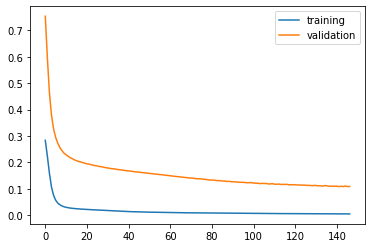

Model: "sequential_26"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_24 (Sequential)  (None, 11)                2112      
                                                                 
 sequential_25 (Sequential)  (None, 192)               2112      
                                                                 
Total params: 4,224
Trainable params: 4,224
Non-trainable params: 0
_________________________________________________________________
Epoch 1/500
16/16 [==============================] - 1s 12ms/step - loss: 0.2799 - val_loss: 0.7296
Epoch 2/500
16/16 [==============================] - 0s 4ms/step - loss: 0.2074 - val_loss: 0.5599
Epoch 3/500
16/16 [==============================] - 0s 4ms/step - loss: 0.1367 - val_loss: 0.4290
Epoch 4/500
16/16 [==============================] - 0s 4ms/step - loss: 0.0860 - val_loss: 0.3457
Epoch 5/500
16/16 [==============================]

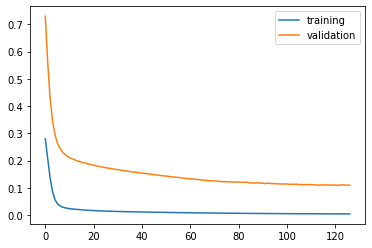

In [ ]:
no_dims = [3, 5, 8, 11]
for dim in no_dims: 
  # define encoder
  encoder = tf.keras.Sequential([
      tf.keras.layers.Dense(dim, input_dim=(df_train_s.shape[1]), activation='tanh', use_bias=False)
  ])

  # define decoder 
  decoder = tf.keras.Sequential([
      tf.keras.layers.Dense(df_train_s.shape[1], input_dim=( dim ), activation='tanh', use_bias=False)
  ])

  # define autoencoder with mean squared error as recreation loss
  autoencoder = tf.keras.Sequential([encoder, decoder])

  autoencoder.compile(loss='mse', optimizer='Adam')

  autoencoder.summary()

  my_callback = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', patience = 5)
  fit_autoencoder = autoencoder.fit(df_train_s, df_train_s, epochs = 500, callbacks = [my_callback], verbose=1, validation_data = (validation_s, validation_s))
  plt.plot(fit_autoencoder.history['loss'], label="training")
  plt.plot(fit_autoencoder.history['val_loss'], label="validation") 
  plt.legend()
  plt.show()
  autoencoders.append(autoencoder)

# Evaluating performance of the autoencoders

Compare the constiuants of top 40 and lowest 40 companies in terms of square root of squared erros (for comparison calculate the percentage of matching companies).

*   Generating the data using autoencoders.
*   Calculating the root mean squared error of predictions of each company for the whole time period for each autoencoder.
*   Extracting the top 40 and bottom 40 companies in terms of error by sorting the errors for each autoencoder.
*   Finding the percent matching of the top and bottom companies between each autoencoder.
*   Plotting the percent matching on a heatmap. 



The intersect matching function will calculate the matching number of entries in two arrays and return the percent of matching entries.

In [ ]:
def intersectMatching(companyArr1, companyArr2):
  intersection = np.intersect1d(companyArr1, companyArr2)
  percentage = len(intersection) / len(companyArr1) * 100
  return percentage


*   I am using a loop to generate results for each autoencoder.
*   Collecting the errors on predictions for training and validation data and storing them in a list for each autoencoder.


In [ ]:
errors_train = []
errors_validation = []
for autoencoder in autoencoders:
  X_train_hat = autoencoder.predict(df_train_s)
  X_test_hat = autoencoder.predict(validation_s)

  # differences of original data and recreations
  Error_train = (df_train_s - X_train_hat)
  Error_test = (validation_s - X_test_hat)

  error_train = pd.DataFrame(Error_train, columns = df_train.columns, index = df_train.index)
  error_test = pd.DataFrame(Error_test, columns = validation.columns, index = validation.index)


  # square root of squared errors
  error_train_rsq = error_train.apply(lambda x: np.sqrt(x**2))
  error_test_rsq = error_test.apply(lambda x: np.sqrt(x**2))

  # average error per company
  error_per_company_train = error_train_rsq.mean(axis = 0)
  error_per_company_test = error_test_rsq.mean(axis = 0)
  errors_train.append(error_per_company_train)
  errors_validation.append(error_per_company_test)

8/8 [==============================] - 0s 2ms/step


Extracting the top and bottom 40 companies using head and tail function after sorting the errors.

In [ ]:
top_companies = []
bottom_companies = []
for error_per_company_validation in errors_validation:
  error_per_company_validation= error_per_company_validation.sort_values()
  top_40 = error_per_company_validation.head(40)
  bottom_40 = error_per_company_validation.tail(40)
  top_companies.append(list(top_40.index))
  bottom_companies.append(list(bottom_40.index))


Finding out the percent matching between the 8 autoencoders for the top 40 and bottom 40 companies and storing them in a dictionary in such a way that each key value pair will have a list in its value which will have the list of percent matching for other autoencoders.

In [ ]:
matchings_top = {}
for i in range(len(top_companies)):
  matchings_top[f'encoder-{i+1}'] = []
  for j in range(len(top_companies)):
    matchings_top[f'encoder-{i+1}'].append(intersectMatching(top_companies[i],top_companies[j]))

In [ ]:
matchings_bottom = {}
for i in range(len(bottom_companies)):
  matchings_bottom[f'encoder-{i+1}'] = []
  for j in range(len(bottom_companies)):
    matchings_bottom[f'encoder-{i+1}'].append(intersectMatching(bottom_companies[i],bottom_companies[j]))

Plotting the heatmaps which visualizes the percent matching of top and bottom companies between autoencoders, which is extracted in the above step.

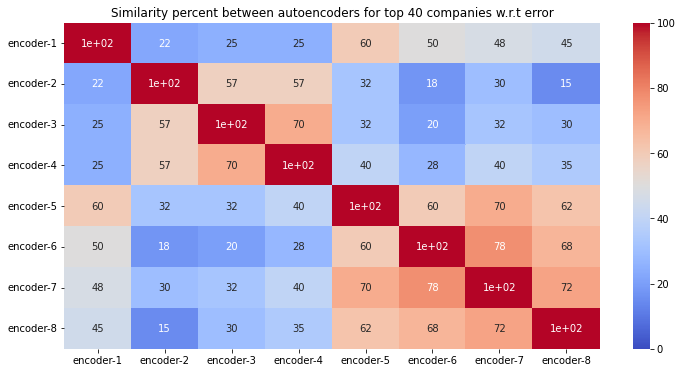

In [ ]:
plt.figure(figsize=(12,6))
sns.heatmap(pd.DataFrame(matchings_top), annot=True, cmap='coolwarm',yticklabels=matchings_top.keys(),vmin=0,vmax=100)
plt.title("Similarity percent between autoencoders for top 40 companies w.r.t error")
plt.show()

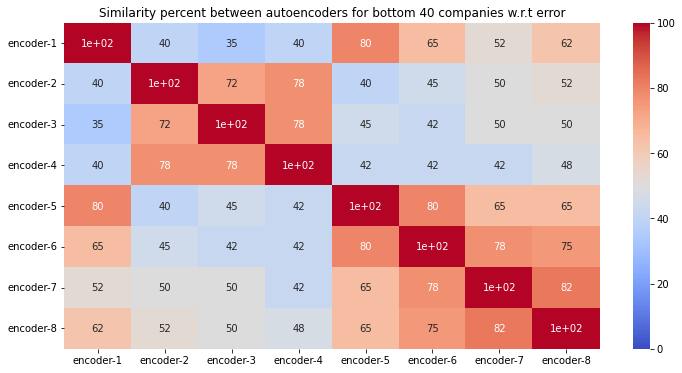

In [ ]:
plt.figure(figsize=(12,6))
sns.heatmap(pd.DataFrame(matchings_bottom), annot=True, cmap='coolwarm',yticklabels=matchings_bottom.keys(),vmin=0,vmax=100)
plt.title("Similarity percent between autoencoders for bottom 40 companies w.r.t error")

plt.show()

The first 4 autoencoders are the linear auto encoders, while the last 4 are the non-linear auto encoders.
It can be seen from the heatmaps that the linear and non-linear autoencoders have tend to pickup similar companies in the bottom 40 companies in terms of errors, while the top 40 are a little diffrent for linear and non-linear. However the autoencoder linear with just 3 dimensions have behaved more like a non-linear autoencoder while picking up the top 40 and bottom 40 companies. 